##**DATA EXPLORATION AND PREPROCESSING**

In [ ]:
!wget -O intents.json https://www.dropbox.com/s/tutk2gx7sqle24r/bot-fix.json?dl=0

--2022-11-20 03:01:10--  https://www.dropbox.com/s/tutk2gx7sqle24r/bot-fix.json?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.85.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.85.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/tutk2gx7sqle24r/bot-fix.json [following]
--2022-11-20 03:01:10--  https://www.dropbox.com/s/raw/tutk2gx7sqle24r/bot-fix.json
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd85ac0b23ab3700b175db55e11.dl.dropboxusercontent.com/cd/0/inline/BxEAK3aHF-zDf-6BGugF5Q8FFYpBTNZPZTRBwv_XPYov36RmvyGSw8ya9pnUyUoEGNaYcRcWqszEldN4vWs7sOQ-kXfgyTaAMFAuWUJCECTHA36SXvKwS6jhK0Sd-oY0jTUpOh2PVIMNSALBGJXYs0bYzbbZcb8jcAi55SSjkB4YGQ/file# [following]
--2022-11-20 03:01:10--  https://ucd85ac0b23ab3700b175db55e11.dl.dropboxusercontent.com/cd/0/inline/BxEAK3aHF-zDf-6BGugF5Q8FFYpBTNZPZTRBwv_XPYov36RmvyGSw8ya9pnUyUoEGNaYcRcW

In [ ]:
import nltk
import json
import pandas as pd
import keras
import pickle
import random
import numpy as np
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPool1D
from nltk.stem import WordNetLemmatizer
lemmatizer=WordNetLemmatizer()

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

##**Load Dataset Json**

Tahapan selanjutnya adalah me-load dataset yang telah disediakan. Data yang dipakai dalam proyek ini menggunakan dataset manual yang dibuat oleh anggota kelompok ini. Dataset yang digunakan berupa format **.json** yang sangat cocok untuk membuat model Chatbot. Data Json merupakan data yang termasuk dalam *semi structured* yang dimana data ini menampung beberapa bagian data seperti **tag**, **pattern**, **context**, dan **response**.

In [ ]:
# Mendapatkan semua data ke dalam list
tags = [] # data tag
inputs = [] # data input atau pattern
responses = {} # data respon
words=[] # Data kata
classes=[] # Data Kelas atau Tag
documents=[] # Data Kalimat Dokumen
ignore=['?','!',',',"'s"] # Mengabaikan tanda spesial karakter

# mengimport dataset yang sudah didownload
data_file=open('/content/intents.json').read()
intents=json.loads(data_file)

In [ ]:
for intent in intents['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])
    for pattern in intent['patterns']:
      w = nltk.word_tokenize(pattern)
      words.extend(w)
      documents.append((w, intent['tag']))
      # add to our classes list
      if intent['tag'] not in classes:
        classes.append(intent['tag'])

In [ ]:
# Melakukan konversi data yang sudah diambil ke dalam dataframe
data = pd.DataFrame({"patterns":inputs, "tags":tags})

In [ ]:
# Melihat isi dari dataframe
data

,patterns,tags
0,hallo,greeting
1,hai,greeting
2,halo,greeting
3,hei,greeting
4,hi,greeting
...,...,...
616,beri saya pantun,pantun
617,bisakah kamu membuat pantun,pantun
618,pantun dong,pantun
619,kasih pantun dong,pantun


In [ ]:
data.tags.unique()

array(['greeting', 'goodbye', 'terimakasih', 'penjelasan_mental_illness',
       'pengidap_mental_illness', 'penyebab_mental_illness',
       'gejala_mental_illness', 'sembuh_mental_illness',
       'obat_mental_illness', 'whatshouldido', 'penyedia_layanan',
       'pengobatan_yang_tersedia', 'perawatan',
       'jenis_profesional_kesehatan_mental',
       'menemukan_profesional_kesehatan_mental', 'pengetahuan_perawatan',
       'bantuan_kesehatan_mental', 'pengetahuan_sebelum_pengobatan_baru',
       'respon_obat', 'membayar_obat', 'terapi_kesehatan_mental',
       'jenis_perawatan_kesehatan_mental',
       'tempat_pendukung_kesehatan_mental', 'rawat_inap', 'layanan_lokal',
       'uji_klinis', 'psikiatri', 'kesehatan_mental', 'dukungan',
       'pencegahan_masalah_kesehatan_mental', 'obat_kesehatan_mental',
       'penyebab_masalah', 'kekhawatiran', 'tidak_sehat',
       'Hubungan_dengan_oranglain', 'apa_yang_harus_dilakukan',
       'Informasi', 'informasi_kesehatan', 'rencana, peme

In [ ]:
data.describe()

,patterns,tags
count,621,621
unique,616,152
top,Apa itu penyakit mental?,greeting
freq,2,15


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 621 entries, 0 to 620
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   patterns  621 non-null    object
 1   tags      621 non-null    object
dtypes: object(2)
memory usage: 9.8+ KB


In [ ]:
data.isnull().sum()

patterns    0
tags        0
dtype: int64

Setelah data tersebut berhasil dikonversi ke dalam sebuah dataframe, maka lankah selanjutnya adalah melakukan **preprocessing data**. 

##**Preprocessing Data**

Tahapan selanjutnya adalah praproses pada dataset yang kita gunakan saat ini, hal ini bertujuan untuk membersihkan data, melakuken tokenisasi pada data text, melakukan vectorisasi pada data text, melakukan encoding, dll. Agar menghasilkan data train yang baik dan model yang baik juga:


1. Remove Punctuations (Menghapus Punktuasi) menghilangkan tanda baca seperti tanda seru, tanda tanya, dll.

In [ ]:
import string
data['patterns'] = data['patterns'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['patterns'] = data['patterns'].apply(lambda wrd: ''.join(wrd))
data

,patterns,tags
0,hallo,greeting
1,hai,greeting
2,halo,greeting
3,hei,greeting
4,hi,greeting
...,...,...
616,beri saya pantun,pantun
617,bisakah kamu membuat pantun,pantun
618,pantun dong,pantun
619,kasih pantun dong,pantun


2.   Lematization (Lematisasi)  merubah suatu kata ke dalam bentuk dasar dari kata tersebut

In [ ]:
words=[lemmatizer.lemmatize(word.lower()) for word in words if word not in ignore]
words=sorted(list(set(words)))
classes=sorted(list(set(classes)))

print (len(words), "unique lemmatized words", words)
print (len(classes), "classes", classes)

665 unique lemmatized words ['(', ')', '-', '.', '19+', '25', '[', ']', 'ada', 'adakah', 'adalah', 'adhd', 'afternoon', 'agama', 'agar', 'akan', 'akibat', 'aku', 'alami', 'alasan', 'alkohol', 'aman', 'ambang', 'anak', 'anak-anak', 'anda', 'aneh', 'antara', 'antidepresan', 'antisosial', 'apa', 'apakah', 'arti', 'article', 'artikel', 'artinya', 'asal', 'aspd', 'assalamualaikum', 'asuransi', 'atau', 'awal', 'bagaimana', 'bagi', 'bagian', 'bagimana', 'bahagia', 'bahwa', 'bai', 'baik', 'banget', 'bantu', 'bantuan', 'bantuanmu', 'banyak', 'banyaknya', 'baru', 'bayar', 'bebahaya', 'beberapa', 'bekerja', 'belajar', 'benar', 'benar-benar', 'bener', 'berada', 'berapa', 'berarti', 'berasal', 'berbagi', 'berbahaya', 'berbiaya', 'berbicara', 'berfikir', 'berguna', 'berhenti', 'beri', 'berjuang', 'berkecukupan', 'berkualitas', 'berlebihan', 'berobat', 'berpelukan', 'berpikir', 'berpotensi', 'bersenang-senang', 'bersepeda', 'berteman', 'bertemu', 'besar', 'betapa', 'biasa', 'biaya', 'bicara', 'bimban

In [ ]:
# menggabungkan pattern dan intents ke dalam documents
print (len(documents), "documents")

3123 documents


3.   Tokenization (Tokenisasi)

In [ ]:
# Tokenize the data (Tokenisasi Data)
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['patterns'])
train = tokenizer.texts_to_sequences(data['patterns'])
train

[[329],
 [330],
 [331],
 [332],
 [333],
 [334],
 [215],
 [216],
 [217],
 [335],
 [336],
 [218],
 [337],
 [338],
 [339],
 [340],
 [341],
 [219],
 [342],
 [220, 219],
 [124, 343],
 [344, 345],
 [346],
 [347, 221],
 [348],
 [349, 221],
 [222, 155],
 [350],
 [222, 155, 67],
 [3, 351, 43, 14, 2],
 [3, 11, 14, 2],
 [3, 11, 2, 68],
 [2, 68, 59],
 [14, 2, 59],
 [352, 2, 68],
 [353, 2, 68],
 [354, 28, 2, 68],
 [60, 5, 12, 61, 14, 2],
 [60, 5, 12, 61, 2, 68],
 [10, 1, 125, 14, 2],
 [10, 1, 125, 8, 2],
 [3, 69, 2, 68],
 [3, 5, 156, 44, 61, 14, 2],
 [3, 69, 14, 2],
 [355, 14, 2, 13, 126],
 [127, 69, 8, 2],
 [3, 127, 356, 69, 14, 2],
 [3, 127, 223, 69, 14, 2],
 [3, 48, 224, 61, 14, 2],
 [3, 31, 61, 14, 2],
 [31, 14, 2],
 [224, 14, 2],
 [31, 357, 14, 2],
 [31, 2, 68],
 [31, 14, 2, 70, 21, 86],
 [31, 14, 2, 70, 128],
 [31, 14, 2, 70, 62],
 [10, 225, 8, 39, 13, 99],
 [32, 358, 14, 2],
 [99, 49, 14, 2],
 [32, 99, 49, 14, 2],
 [10, 8, 39, 13, 226],
 [10, 8, 39, 13, 99],
 [18, 7, 14, 2],
 [71, 3, 5, 50, 

4.   Melakukan Encoding dan Apply Padding

In [ ]:
# Apply padding 
x_train = pad_sequences(train)

# Encoding the outputs 
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])

In [ ]:
print(x_train) # Padding Sequences

[[  0   0   0 ...   0   0 329]
 [  0   0   0 ...   0   0 330]
 [  0   0   0 ...   0   0 331]
 ...
 [  0   0   0 ...   0  98 328]
 [  0   0   0 ... 155  98 328]
 [  0   0   0 ...   0 658  98]]


In [ ]:
print(y_train) #Label Encodings

[ 51  51  51  51  51  51  51  51  51  51  51  51  51  51  51  50  50  50
  50  50  50  50  50  50 143 143 143 143 143 107 107 107 107 107 107 107
 107 105 105 105 105 111 111 111 111 111 111 111  46  46  46  46  46  46
  46  46  46 137 137 137 137 137 137  95  95  95  95 150 150 150 150 150
 150 112 112 112 112 112 106 106 106 106 106 114 114 114 114 114 114 114
 114  63  63  63  63  80  80 102 102 102 102 102  15  15  15  15  15  15
 103 103 103 103 103 103 103 103 132 132 132 132 132 132  79  79  79  79
  79  79  79 142 142 142 142 142 142  62  62  62  62  62  63  63 141 141
 141 141 125 125 125 125 125 125  76  76  76  76 146 146 146 146 146 120
 120 120 120  71  71  71  38  38  38 101 101 101 101  94  94  94  94 110
 110 110 110  66  66  66 145 145 145   3   3   3  12  12   4   4   4  60
  60  60 129 129 129  56  56  56  82  82  82  81  81  19  19  19  19  19
 113 113 113  69  69  69  69  69  37  37  37 118 118 118 118 122 122 122
 122  73  73  73  73  73  67  67  67  67  75  75  7

Tokenizer pada Tensorflow memberikan token unik untuk setiap kata yang berbeda. Dan juga padding dilakukan untuk mendapatkan semua data dengan panjang yang sama sehingga dapat mengirimkannya ke lapisan atau layer RNN. variabel target juga dikodekan menjadi nilai desimal.

##**MODELING**

In [ ]:
# input length
input_shape = x_train.shape[1]
print(input_shape)

23


In [ ]:
# define vocabulary
vocabulary = len(tokenizer.word_index)
print("Jumlah kata unik : ", vocabulary)

# output length
output_length = le.classes_.shape[0]
print("Panjang output : ", output_length)

Jumlah kata unik :  658
Panjang output :  152


**Input length** dan **output length** terlihat sangat jelas hasilnya. Mereka adalah untuk bentuk input dan bentuk output dari jaringan syaraf pada algoritma Neural Network.

**Vocabulary Size** adalah untuk lapisan penyematan untuk membuat representasi vektor unik untuk setiap kata.

**Save Model Words & Classes**

In [ ]:
pickle.dump(words, open('/content/words.pkl','wb'))
pickle.dump(classes, open('/content/classes.pkl','wb'))

In [ ]:
#training data
training=[]
output_empty=[0]*len(classes)

In [ ]:
for doc in documents:
    bag=[] # list bag of word
    pattern=doc[0]
    pattern=[ lemmatizer.lemmatize(word.lower()) for word in pattern ]
    
    for word in words: 
        if word in pattern:
            bag.append(1)
        else:
            bag.append(0)
    output_row=list(output_empty)
    output_row[classes.index(doc[1])]=1
    
    training.append([bag,output_row])
    
random.shuffle(training)
training=np.array(training)  
X_train=list(training[:,0])
y_train=list(training[:,1]) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
training

array([[list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
#Membuat model seq2seq untuk training data
model=Sequential()
model.add(Dense(128,activation='relu',input_shape=(len(X_train[0]),)))
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(y_train[0]),activation='softmax'))

In [ ]:
# Compiling the model (Kompilasi Model)
adam=keras.optimizers.Adam(0.001)
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy']) 

In [ ]:
# Training the model (Latih Model Data)
weights=model.fit(np.array(X_train),np.array(y_train),epochs=400,batch_size=10,verbose=1)   

Epoch 1/400
313/313 [==============================] - 2s 3ms/step - loss: 4.5405 - accuracy: 0.0970
Epoch 2/400
313/313 [==============================] - 1s 4ms/step - loss: 3.4443 - accuracy: 0.2334
Epoch 3/400
313/313 [==============================] - 1s 4ms/step - loss: 2.6615 - accuracy: 0.3788
Epoch 4/400
313/313 [==============================] - 1s 4ms/step - loss: 2.1966 - accuracy: 0.4717
Epoch 5/400
313/313 [==============================] - 1s 4ms/step - loss: 1.8258 - accuracy: 0.5540
Epoch 6/400
313/313 [==============================] - 1s 3ms/step - loss: 1.5440 - accuracy: 0.6087
Epoch 7/400
313/313 [==============================] - 1s 3ms/step - loss: 1.3455 - accuracy: 0.6523
Epoch 8/400
313/313 [==============================] - 1s 3ms/step - loss: 1.2023 - accuracy: 0.6763
Epoch 9/400
313/313 [==============================] - 1s 3ms/step - loss: 1.0657 - accuracy: 0.7041
Epoch 10/400
313/313 [==============================] - 1s 3ms/step - loss: 0.9333 - accura

**Save Model hasil training**

In [ ]:
#save model
model.save('mymodel.h5',weights)

In [ ]:
model.summary() # Menampilkan Parameter Model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               85248     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 152)               9880      
                                                                 
Total params: 107,544
Trainable params: 107,544
Non-trai

# **Model Analysis & Visualization**

Setelah menjalankan model fitting. Selanjutnya adalah analisa model untuk melihat hasil akurasi dari model Neural Network tersebut.

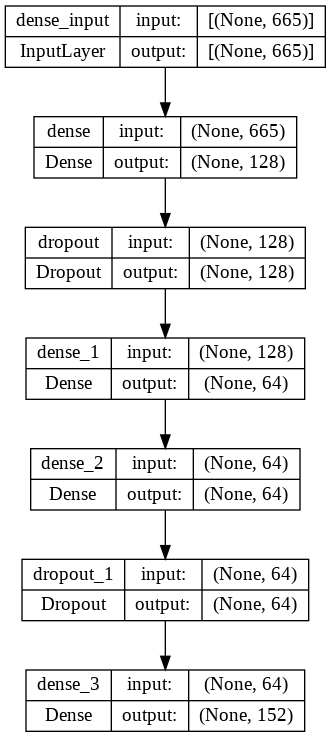

In [ ]:
# Visualization Plot Architecture Model (Visualisasi Plot Arsitektur Model)
plot_model(model, to_file='/content/model_plot.png', show_shapes=True, show_layer_names=True)

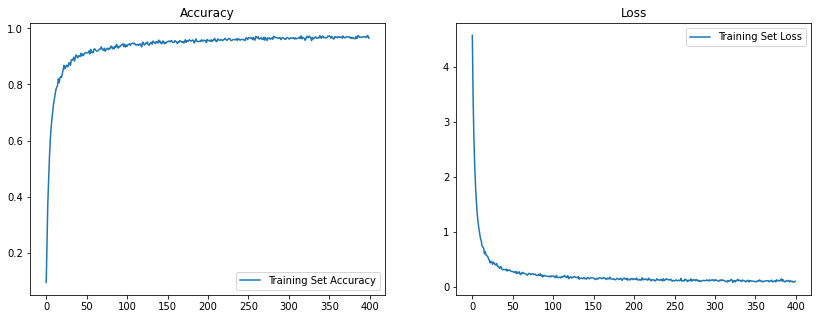

In [ ]:
# Plotting model Accuracy and Loss (Visualisasi Plot Hasil Akurasi dan Loss)
# Plot Akurasi
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(weights.history['accuracy'],label='Training Set Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(weights.history['loss'],label='Training Set Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()